# Notebook for EDA
For presentation, I have prepared 5 plots.
1. Average Daily Count separated by Month
2. Average Daily Count separated by Day of Week
3. 2020 vs 2019 Total Count comparison
4. 2020 Event plot
5. Train test split plots

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

from tqdm import tqdm
from fbprophet import Prophet

import lightgbm as lgb
import holidays

In [2]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])

In [13]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [14]:
def date_features(_df):
    """
    extract datetime features
    """
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, 5)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    
    
    return _df

In [25]:
df = return_series('mta.csv')
_df = df.unstack().T
_df = _df['2018':].copy(deep=True)
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')
    
_df = _df.reset_index()
_df['total_count'] = _df.set_index('datetime').sum(axis=1).values
_df.head()

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,total_count
0,2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286,586763
1,2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211,700586
2,2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974,758969
3,2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114,244558
4,2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229,555112


In [26]:
_df = date_features(_df.set_index('datetime'))
_df.reset_index(inplace=True)
_df['dayofyear'] = _df['datetime'].dt.dayofyear

Text(0, 0.5, 'Count')

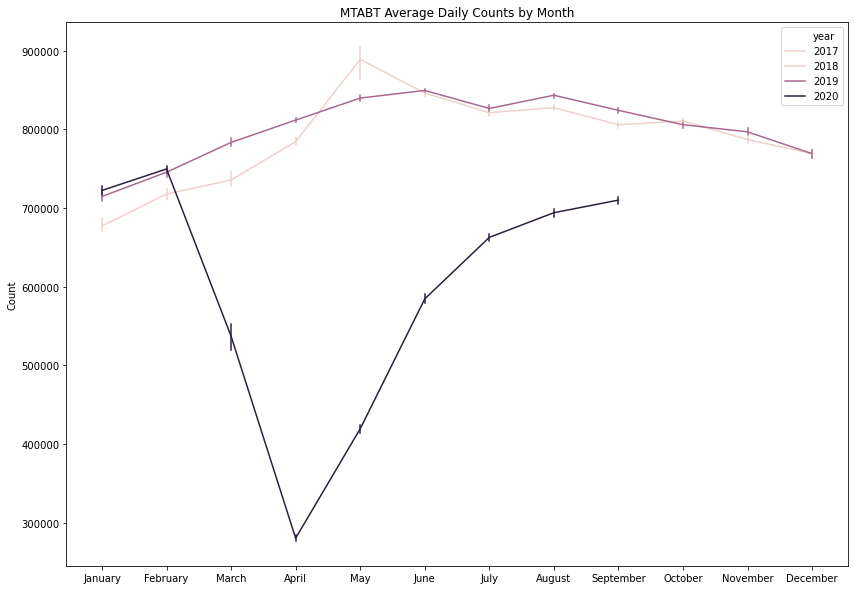

In [35]:
plt.figure(figsize=(14,10))
g= sns.lineplot(x='month', y='total_count', hue='year', data= _df.set_index('datetime')['2018':'2020'], markers=True, err_style='bars', ci=34)
plt.title('MTABT Average Daily Counts by Month')
g.set_xticks(range(1,13))
g.set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'])
g.set_xlabel('')
g.set_ylabel('Count')
# plt.savefig('Monthly', bbox_inches ='tight', pad_inches=0.5);

Text(0, 0.5, 'Count')

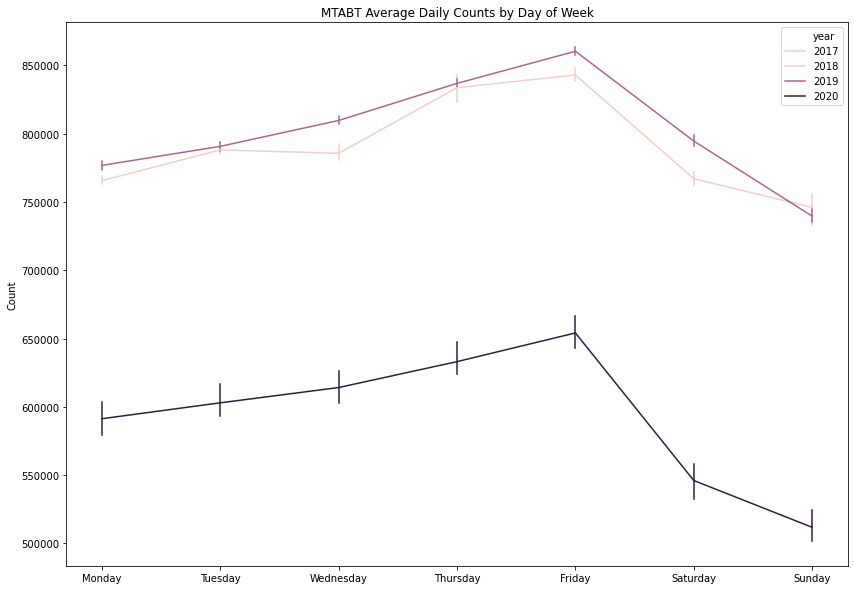

In [36]:
plt.figure(figsize=(14,10))
g= sns.lineplot(x='dayofweek', y='total_count', hue='year', data= _df.set_index('datetime')['2018':'2020'], markers=True, err_style = 'bars', ci=34)
plt.title('MTABT Average Daily Counts by Day of Week')
g.set_xticks(range(7))
g.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
g.set_xlabel('')
g.set_ylabel('Count')
# plt.savefig('DayofWeek', bbox_inches ='tight', pad_inches=0.5);

Text(0.5, 0, '')

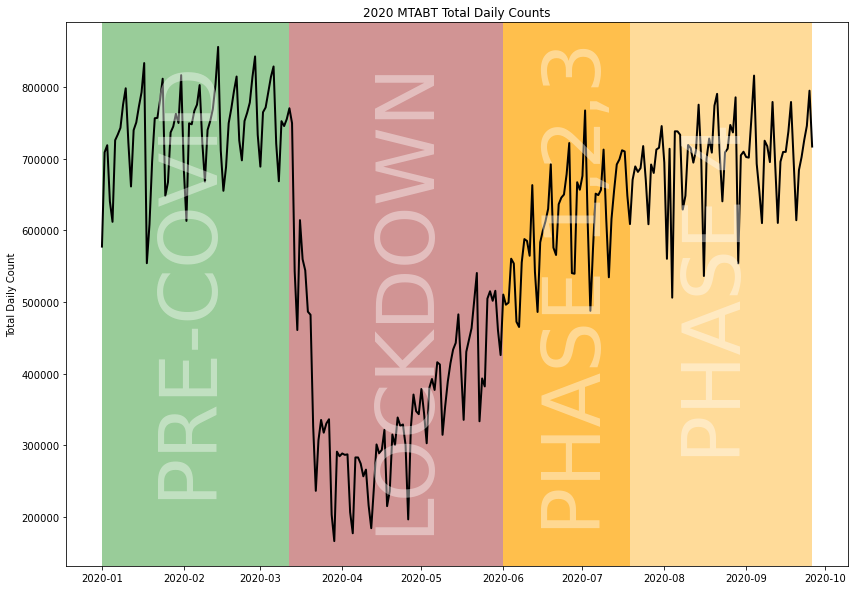

In [29]:

fig, ax = plt.subplots(figsize=(14,10))
ax.plot(_df.loc[_df['datetime'] >= '2020']['datetime'], 
        _df.loc[_df['datetime'] >= '2020']['total_count'], lw=2, color='black')
ax.axvspan(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 3, 12), facecolor='green', alpha=0.4)
ax.axvspan(datetime.datetime(2020, 3, 12), datetime.datetime(2020, 6, 1), facecolor='brown', alpha=0.5)




ax.axvspan(datetime.datetime(2020, 6, 1), datetime.datetime(2020, 7, 19), facecolor='orange', alpha=0.7)

ax.axvspan(datetime.datetime(2020, 7, 19), datetime.datetime(2020, 9, 26), facecolor='orange', alpha=0.4)
ax.annotate("PRE-COVID", xy=(datetime.datetime(2020, 4,15), 500000), xytext=(datetime.datetime(2020, 1,19), 250000), fontsize=80, rotation = 90, alpha= 0.4, color = 'white')
ax.annotate("LOCKDOWN", xy=(datetime.datetime(2020, 4,15), 500000), xytext=(datetime.datetime(2020, 4,10), 200000), fontsize=80, rotation = 90, alpha= 0.4, color = 'white')
ax.annotate("PHASE 1,2,3", xy=(datetime.datetime(2020, 4,15), 500000), xytext=(datetime.datetime(2020, 6,15), 200000), fontsize=80, rotation = 90, alpha= 0.4, color = 'white')
ax.annotate("PHASE 4", xy=(datetime.datetime(2020, 4,15), 500000), xytext=(datetime.datetime(2020, 8,7), 300000), fontsize=80, rotation = 90, alpha= 0.4, color = 'white')
ax.set_title('2020 MTABT Total Daily Counts')
ax.set_ylabel('Total Daily Count')
ax.set_xlabel('')
# plt.savefig('covid_events', bbox_inches ='tight', pad_inches=0.5);

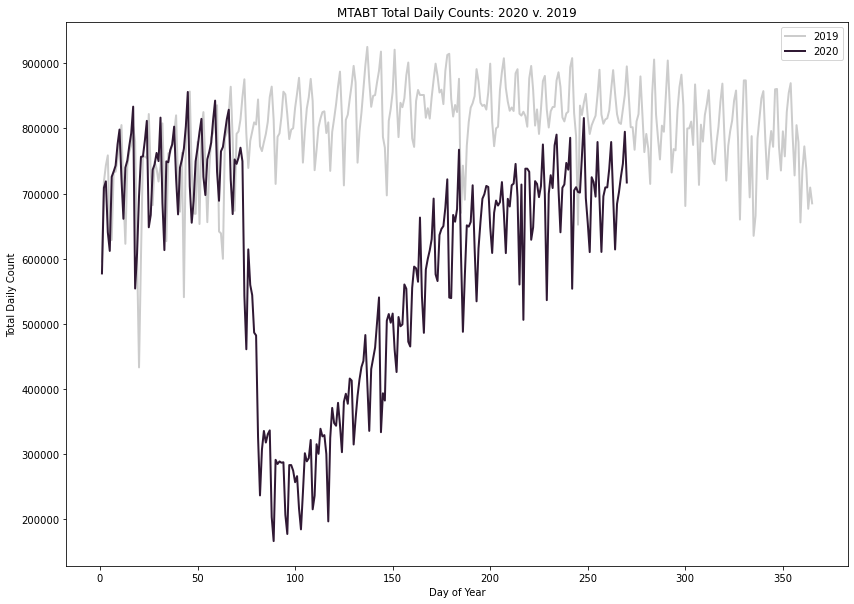

In [30]:

fig, ax = plt.subplots(figsize=(14,10))


ax.plot(_df.loc[(_df['datetime'] >= '2019') & (_df['datetime'] < '2020')]['dayofyear'], 
        _df.loc[(_df['datetime'] >= '2019') & (_df['datetime'] < '2020')]['total_count'], lw=2, color='black', alpha = 0.2, label='2019')
ax.plot(_df.loc[_df['datetime'] >= '2020']['dayofyear'], 
        _df.loc[_df['datetime'] >= '2020']['total_count'], lw=2, color='#301934' , label = '2020')

ax.set_title('MTABT Total Daily Counts: 2020 v. 2019')
ax.set_ylabel('Total Daily Count')
ax.set_xlabel('Day of Year')
ax.legend(loc='upper right')
# plt.savefig('2020v2019', bbox_inches ='tight', pad_inches=0.5);

In [37]:
_df.set_index('datetime' , inplace=True)

Text(0.5, 1.0, 'Time Based Cross Validation')

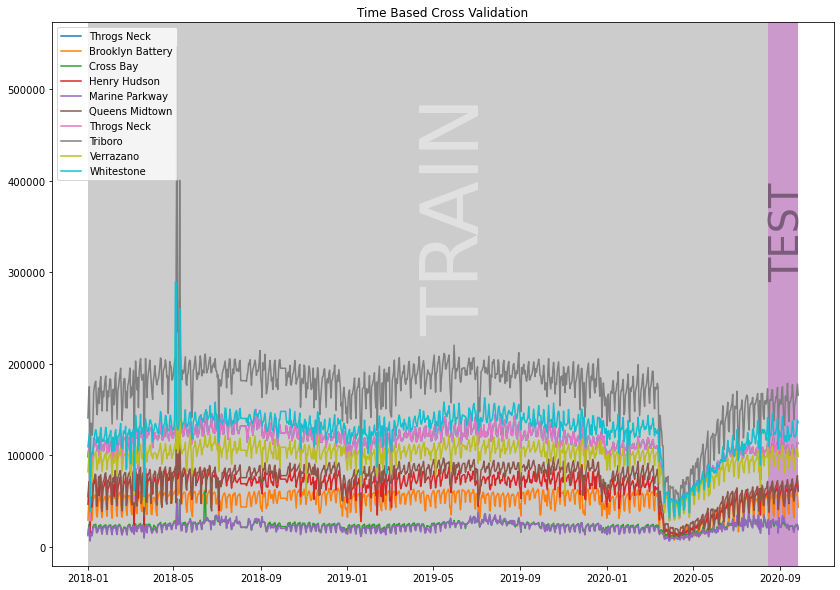

In [40]:
plt.figure(figsize=(14,10))
plt.plot(_df.index, _df['Throgs Neck'], label= 'Throgs Neck')
plt.plot(_df.index, _df['Brooklyn Battery'], label = 'Brooklyn Battery')
plt.plot(_df.index, _df['Cross Bay'], label = 'Cross Bay')
plt.plot(_df.index, _df['Henry Hudson'], label = 'Henry Hudson')
plt.plot(_df.index, _df['Marine Parkway'], label = 'Marine Parkway')
plt.plot(_df.index, _df['Queens Midtown'], label = 'Queens Midtown')
plt.plot(_df.index, _df['Throgs Neck'], label = 'Throgs Neck')
plt.plot(_df.index, _df['Triboro'], label = 'Triboro')
plt.plot(_df.index, _df['Verrazano'], label = 'Verrazano')
plt.plot(_df.index, _df['Whitestone'], label = 'Whitestone')
plt.axvspan(datetime.datetime(2018, 1, 1), datetime.datetime(2020, 8, 14), facecolor='grey', alpha=0.4)
plt.axvspan(datetime.datetime(2020, 8, 14), datetime.datetime(2020, 9, 26), facecolor='purple', alpha=0.4)
text = plt.annotate("TRAIN", xy=(datetime.datetime(2019, 4,15), 500000), xytext=(datetime.datetime(2019, 4,10), 250000), fontsize=80, rotation = 90, alpha= 0.4, color = 'white')
text = plt.annotate("TEST", xy=(datetime.datetime(2020, 9,1), 500000), xytext=(datetime.datetime(2020, 8,15), 300000), fontsize=40, rotation = 90, alpha= 0.4, color = 'black')
plt.legend(loc = 'upper left')
plt.title('Time Based Cross Validation')
# plt.savefig('traintest', bbox_inches ='tight', pad_inches=0.5);